In [2]:
import slim_conservation_scoring.seqtools.general_utils as tools
import pandas as pd
import numpy as np
import slim_conservation_scoring.pipeline.group_conservation_objects as group_tools
import json
import os
import re
import sys
from pathlib import Path
from Bio import AlignIO, Seq, SeqIO, Align

import matplotlib.pyplot as plt
plt.style.use('custom_standard')
# plt.style.use('custom_small')
import seaborn as sns
# pd.options.plotting.backend = "plotly"
from ast import literal_eval

# %load_ext autoreload
# %autoreload 2

In [3]:
zscores = pd.read_csv('./z_scores_wideform.csv')
score_key = pd.read_csv('./z_scores_score_key.csv')
score_indexes=[i for i in zscores.columns if i in score_key['score_index'].unique()]

for col in score_indexes:
    zscores[col] = zscores[col].apply(literal_eval)

zscores['mask_array'] = zscores['mask_array'].str.replace(' ', ',')
zscores['mask_array'] = zscores['mask_array'].apply(literal_eval)
zscores['mask_array'] = zscores['mask_array'].apply(np.array)

def extract_important_scores(s, colname):
    scores = np.array(s[colname])
    maskarr = np.array(s["mask_array"])
    mask = maskarr.nonzero()
    return scores[mask]

zscores2=zscores.copy()
for i in score_indexes:
    zscores2[i] = zscores2.apply(lambda x: extract_important_scores(x, i), axis=1)
    zscores2[i] = zscores2[i].apply(np.mean)

# zscores2 = zscores2[zscores2['ELM_motif_class'] != 'TRAF6']
passing_ref_id_list = zscores['reference_index'].unique()

In [4]:
zscores['mask_array'].isnull().sum()

np.int64(0)

# supplemental table - counts for each set for each SLiM in the benchmark

In [5]:
supp_folder = Path('./supplement')
class_counts_folder = supp_folder / 'benchmark_class_counts'
class_counts_folder.mkdir(exist_ok=True, parents=True)
# zscores.groupby('verified interaction')['ELM_motif_class'].value_counts().unstack().to_csv(class_counts_folder / 'benchmark_class_counts.csv')
# zscores.groupby('verified interaction')['ELM_motif_class'].value_counts().unstack()
temp = zscores.groupby('verified interaction')['ELM_motif_class'].value_counts().unstack().T.copy()
re_map = zscores.groupby('ELM_motif_class').first()['regex'].to_dict()
mask_map = zscores.groupby('ELM_motif_class').first()['mask_array'].to_dict()
mask_map['LIG_14-3-3_CanoR_1'] = 'No mask'
temp['regex'] = temp.index.map(re_map)
temp['mask_array'] = temp.index.map(mask_map)
temp.to_csv(class_counts_folder / 'benchmark_class_counts.csv')
temp

verified interaction,False,True,regex,mask_array
ELM_motif_class,,,,
DOC_WW_Pin1_4,253,40,...([ST])P.,"[0, 0, 0, 1, 1, 0]"
Ena/VASP ([FL]PPPP),236,34,[FL]PPPP,"[1, 1, 0, 1, 1]"
LIG_14-3-3_CanoR_1,242,42,"R[^DE]{0,2}[^DEPG]([ST])(([FWYLMV].)|([^PRIKGN...",No mask
LIG_AP2alpha_2,244,49,DP[FW],"[1, 1, 1]"
LIG_EH_1,264,49,.NPF.,"[0, 1, 1, 1, 0]"
LIG_SH2_GRB2like,238,18,(Y)([EDST]|[MLIVAFYHQW])N.,"[1, 1, 1, 0]"
LIG_SH3_CIN85_PxpxPR_1,224,28,P.[AP].PR,"[1, 0, 1, 0, 1, 1]"
TRAF6,216,7,...P.E..[FYWDE],"[0, 0, 0, 1, 0, 1, 0, 0, 1]"


# supplementary table - conservation scores

In [6]:
score_indexes

['0.0',
 '2.0',
 '4.0',
 '8.0',
 '9.0',
 '19.0',
 '22.0',
 '26.0',
 '27.0',
 '30.0',
 '31.0',
 '34.0',
 '35.0',
 '38.0',
 '39.0',
 'kibby_hit_zscores']

In [7]:
score_key[(score_key['lflank']!='5.0')]

,score_index,aln_type,level,score_key,table_file,lflank,rflank,columnwise_score_function_name,num_passing
0,0.0,MSA - MAFFT,Tetrapoda,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2464
1,1.0,MSA - MAFFT,Tetrapoda,aln_shannon_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,shannon_entropy,2464
2,2.0,MSA - MAFFT,Vertebrata,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2606
3,3.0,MSA - MAFFT,Vertebrata,aln_shannon_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,shannon_entropy,2606
4,4.0,MSA - MAFFT,Metazoa,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2404
5,5.0,MSA - MAFFT,Metazoa,aln_shannon_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,shannon_entropy,2404
6,6.0,Pairwise,Tetrapoda,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,shannon_entropy,2663
8,8.0,Pairwise,Tetrapoda,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2663
10,10.0,Pairwise,Vertebrata,pairk_aln_lf0_rf0_blosum62,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,shannon_entropy,2823
11,11.0,Pairwise,Vertebrata,pairk_aln_lf0_rf0_grantham,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,shannon_entropy,2823


In [8]:
# score_key_filt = score_key[score_key['score_index'].isin(score_indexes)]
# score_key_filt = score_key_filt[score_key_filt['score_index']!= 'kibby_hit_zscores']

In [9]:
cols2export=list(score_key[
    (~score_key['lflank'].isin(['5.0','10.0','2.0']))&
    (score_key['columnwise_score_function_name']!='shannon_entropy')&
    (~score_key['score_key'].isin(['pairk_aln_lf0_rf0_blosum62','pairk_aln_lf0_rf0_grantham', 'kibby', 'pairk_aln_needleman_lf0_rf0_edssmat50']))
].score_index.unique())
score_key_for_rename = score_key[score_key['score_index'].isin(cols2export)].copy()

In [10]:
# score_key_for_rename['aln_type'] = score_key_for_rename['aln_type'].replace('Pairwise', 'pairk')
# score_key_for_rename['aln_type'] = score_key_for_rename['aln_type'].replace('Pairwise embedding', 'pairk - ESM2 embeddings')
def rename_aln_type(s):
    aln_type = s['aln_type']
    score_key = s['score_key']
    if aln_type == 'MSA - MAFFT':
        return aln_type
    elif aln_type == 'Pairwise':
        return 'pairk'
    elif score_key == 'pairk_aln_dr_bert_embedding_lf0_rf0':
        return 'pairk - DR-BERT embeddings'
    elif score_key == 'pairk_aln_embedding_lf0_rf0':
        return 'pairk - ESM2 embeddings'
    else:
        return aln_type


score_key_for_rename['aln_type'] = score_key_for_rename.apply(rename_aln_type, axis=1)

In [11]:
score_key_for_rename

,score_index,aln_type,level,score_key,table_file,lflank,rflank,columnwise_score_function_name,num_passing
0,0.0,MSA - MAFFT,Tetrapoda,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2464
2,2.0,MSA - MAFFT,Vertebrata,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2606
4,4.0,MSA - MAFFT,Metazoa,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2404
8,8.0,pairk,Tetrapoda,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2663
19,19.0,pairk,Vertebrata,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2823
26,26.0,pairk,Metazoa,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2844
30,30.0,pairk - ESM2 embeddings,Tetrapoda,pairk_aln_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2663
31,31.0,pairk - DR-BERT embeddings,Tetrapoda,pairk_aln_dr_bert_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2663
34,34.0,pairk - ESM2 embeddings,Vertebrata,pairk_aln_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2823
35,35.0,pairk - DR-BERT embeddings,Vertebrata,pairk_aln_dr_bert_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2823


In [12]:
score_key[score_key['score_index'].isin(cols2export)]

,score_index,aln_type,level,score_key,table_file,lflank,rflank,columnwise_score_function_name,num_passing
0,0.0,MSA - MAFFT,Tetrapoda,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2464
2,2.0,MSA - MAFFT,Vertebrata,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2606
4,4.0,MSA - MAFFT,Metazoa,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2404
8,8.0,Pairwise,Tetrapoda,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2663
19,19.0,Pairwise,Vertebrata,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2823
26,26.0,Pairwise,Metazoa,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2844
30,30.0,Pairwise embedding,Tetrapoda,pairk_aln_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2663
31,31.0,Pairwise embedding,Tetrapoda,pairk_aln_dr_bert_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2663
34,34.0,Pairwise embedding,Vertebrata,pairk_aln_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2823
35,35.0,Pairwise embedding,Vertebrata,pairk_aln_dr_bert_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2823


In [13]:
zscores2.columns

Index(['reference_index', 'ELM_motif_class', 'verified interaction', 'regex',
       'UniprotID', 'name', 'gene_id', 'hit end position',
       'hit start position', 'hit_sequence', 'json_file', '0.0-bg_STD', '0.0',
       '2.0', '2.0-bg_STD', '4.0', '4.0-bg_STD', '8.0', '8.0-bg_STD', '9.0',
       '9.0-bg_STD', '19.0', '19.0-bg_STD', '22.0', '22.0-bg_STD', '26.0',
       '26.0-bg_STD', '27.0', '27.0-bg_STD', '30.0', '30.0-bg_STD', '31.0',
       '31.0-bg_STD', '34.0', '34.0-bg_STD', '35.0', '35.0-bg_STD', '38.0',
       '38.0-bg_STD', '39.0', '39.0-bg_STD', 'hit_length', 'mask_array',
       'kibby_hit_zscores-bg_STD', 'kibby_hit_zscores'],
      dtype='object')

In [14]:
score_key[(score_key['score_key']=='pairk_aln_dr_bert_embedding_lf0_rf0') & (score_key['level']=='Metazoa')]['score_index'].values[0]

'37.0'

<Axes: xlabel='39.0', ylabel='38.0'>

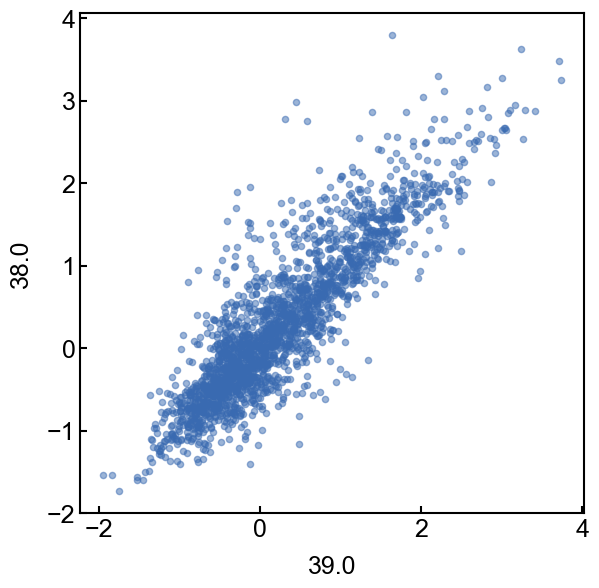

In [15]:
zscores2.plot(
    kind='scatter',
    x=score_key_for_rename[(score_key_for_rename['score_key']=='pairk_aln_dr_bert_embedding_lf0_rf0') & (score_key_for_rename['level']=='Metazoa')]['score_index'].values[0], 
    y=score_key_for_rename[(score_key_for_rename['score_key']=='pairk_aln_embedding_lf0_rf0') & (score_key_for_rename['level']=='Metazoa')]['score_index'].values[0], 
    alpha=0.5
)

In [16]:
zscores_export = zscores2[
    [
        'ELM_motif_class',
        'verified interaction',
        'regex',
        'UniprotID',
        'gene_id',
        'hit start position',
        'hit end position',
        'hit_sequence',
        'mask_array',
    ]
    + cols2export
    + ['kibby_hit_zscores']
].copy()
rn_dict = {
    'ELM_motif_class': 'SLiM class',
    'gene_id': 'OrthoDB id',
    'kibby_hit_zscores': 'Kibby',
}
zscores_export = zscores_export.rename(columns=rn_dict)

def score_index_2_col_title(score_index, score_key_df):
    df = score_key_df[score_key_df['score_index']==score_index].copy()
    assert len(df)==1, f"More than one match for {score_index}"
    level=df['level'].values[0]
    aln_type=df['aln_type'].values[0]
    title = f'{aln_type} - {level}'
    return title

rn_dict2 ={}
for i in cols2export:
    rn_dict2[i] = score_index_2_col_title(i, score_key_for_rename)
zscores_export = zscores_export.rename(columns=rn_dict2)
zscores_export

,SLiM class,verified interaction,regex,UniprotID,OrthoDB id,hit start position,hit end position,hit_sequence,mask_array,MSA - MAFFT - Tetrapoda,...,pairk - Tetrapoda,pairk - Vertebrata,pairk - Metazoa,pairk - ESM2 embeddings - Tetrapoda,pairk - DR-BERT embeddings - Tetrapoda,pairk - ESM2 embeddings - Vertebrata,pairk - DR-BERT embeddings - Vertebrata,pairk - ESM2 embeddings - Metazoa,pairk - DR-BERT embeddings - Metazoa,Kibby
0,LIG_AP2alpha_2,True,DP[FW],O08838,10116_0:004cdf,356,358,DPF,"[1, 1, 1]",1.312759,...,0.765409,0.387204,-0.484739,1.047175,1.013069,0.779145,0.796783,-0.120440,-0.386975,1.727165
1,LIG_AP2alpha_2,True,DP[FW],Q05140,10116_0:002e5e,399,401,DPF,"[1, 1, 1]",0.180739,...,0.284105,0.369749,0.344503,0.547614,0.695188,0.943751,0.943101,0.766580,0.153389,2.232242
2,LIG_AP2alpha_2,True,DP[FW],Q05140,10116_0:002e5e,473,475,DPF,"[1, 1, 1]",-0.091241,...,0.284105,0.369749,0.344503,0.547614,0.655126,0.939865,0.953528,0.753180,-0.054654,2.818305
3,LIG_AP2alpha_2,True,DP[FW],P98082,9606_0:0016b2,292,294,DPF,"[1, 1, 1]",1.385546,...,0.907574,1.022667,1.213079,1.233372,1.275655,1.392867,1.531477,1.850676,2.139386,1.770583
4,LIG_AP2alpha_2,True,DP[FW],P98082,9606_0:0016b2,297,299,DPF,"[1, 1, 1]",1.432202,...,0.907574,1.022667,1.213079,1.233372,1.322427,1.174462,1.572096,1.721991,2.125618,1.799091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,TRAF6,False,...P.E..[FYWDE],Q13029,9606_0:0000cd,205,213,AEGPKEDEE,"[0, 0, 0, 1, 0, 1, 0, 0, 1]",0.103647,...,0.222781,0.286644,0.280290,0.164704,0.230473,0.259271,0.285934,0.214220,0.316458,-0.310576
2180,TRAF6,False,...P.E..[FYWDE],Q5TGL8,9606_0:001a26,197,205,SEFPSELED,"[0, 0, 0, 1, 0, 1, 0, 0, 1]",0.076664,...,0.198238,-0.262641,-0.262641,0.148587,0.321642,-0.040602,-0.223374,-0.040602,-0.223374,0.818403
2181,TRAF6,False,...P.E..[FYWDE],A0A1B0GUS7,9606_0:002617,3076,3084,ACEPKEMKE,"[0, 0, 0, 1, 0, 1, 0, 0, 1]",-0.409375,...,-0.111811,-0.111811,-0.111811,0.158171,0.188132,0.158171,0.188132,0.158171,0.188132,-0.568441
2182,TRAF6,False,...P.E..[FYWDE],B2RAH2,9606_0:00030a,654,662,VADPYEEAW,"[0, 0, 0, 1, 0, 1, 0, 0, 1]",0.225050,...,0.357727,0.769396,-0.324706,0.435941,0.584219,0.770882,0.990531,0.144190,0.127520,2.437533


In [17]:
zscores_export=zscores_export.rename(columns={'hit start position': 'match start position', 'hit end position': 'match end position', 'hit_sequence': 'match sequence'})

In [18]:
output_dir=supp_folder / 'benchmark_zscores'
output_dir.mkdir(exist_ok=True, parents=True)
zscores_export.to_csv(output_dir / 'benchmark_scores_v2.csv', index=False)